## Notes for reader

* To install Geopandas (finally...), you probably need to create a new conda environment and install geopandas there.
    * I used the following commands in Anaconda prompt running as admin, on windows: 
        * "conda install -n base nb_conda_kernels"
        * "conda create -n geopandas_env geopandas ipykernel"
            * "geopandas_env" (in the above line)) is just what I named my new environment, you can name it whatever you want
        * Finally, switch the kernel in your Jupyter notebook

# Summary:

## 

This work follows Bruckner and Ciccone (2011), who found that the negative exogenous economic shocks which followed droughts in sub-Saharan Africa were solid contributors to / predictors of democratic revolutions. 

I attempt to establish a relationship between droughts (again serving as negative exogenous economic shocks) and political change, which might take any of the following forms:
* Increased votes for a specific pro-farmer party (will have to investigate whether democrats or republicans are viewed as pro-farmer.)
* Increased probability of an incumbent losing
* Increased votes for the Democratic party, who generally favor greater redistribution (see: Acemoglu & Robinson)

  
  
 newline

The equation of interest takes the form \begin{equation} Y_{i,t} = \alpha \, * Drought_{i,t} + \beta'X_{i,t} + \phi_{i,t} + \psi_{i,t} + u_{i,t} \end{equation}

where 
* $Y_{i,t} = $ our outcome of interest - either vote share for a particular party; probability of an incumbent losing; etc.
* $\alpha = $ the effect of drought on the outcome of interest
* ~~$X_{i,t} = $ characteristics of the district at time *t*, such as income, farming as a share of GDP, average farm size, etc.~~
* $\phi_{i,t} = $ state fixed effects
* $\psi_{i,t} = $ time fixed effects

# Non-Geo Data Import and Cleaning

## Import and Setup

In [158]:
import pandas as pd
import numpy as np
import pickle

In [159]:
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', 199)
pd.options.display.float_format = '{:.2f}'.format

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

## Denote "BASE_YEAR" variable

This is the first year where we have data available for all datasets in the analysis (with a few years for margin of error)

In [160]:
BASE_YEAR = 1998

# currently strictest year limitation comes from the drought dataset 

## Market Value by District Data

Note: Due to data/time limitations, I'm assuming that congressional districts that are currently highly agricultural were also highly agricultural over the period I examine. This is one place to expand my analysis when I have more time

In [161]:
# from 
# https://www.nass.usda.gov/Publications/AgCensus/2012/Online_Resources/Congressional_District_Rankings/ , and
# https://www.nass.usda.gov/Publications/AgCensus/2017/Online_Resources/Congressional_District_Rankings/
farm_census_2012 = pd.read_csv(r"C:\Users\mikha\OneDrive\Desktop\Dropbox\MIKHAEL NEW\mikhael school\Grad School\Master's\Term 2 Classes\544\Replication\My Addition\Mkt Value of Agr Products Sold\2012.csv")
farm_census_2017 = pd.read_csv(r"C:\Users\mikha\OneDrive\Desktop\Dropbox\MIKHAEL NEW\mikhael school\Grad School\Master's\Term 2 Classes\544\Replication\My Addition\Mkt Value of Agr Products Sold\2017.csv")

farm_census_2012['year'] = 2012
farm_census_2017['year'] = 2017

# merge 2012 and 2017
farm_census = pd.concat([farm_census_2012, farm_census_2017])

#delete old dataframes
del farm_census_2012, farm_census_2017

### Replace "AT LARGE" districts with 0

In [162]:
# temp_district = [x for x in farm_census['district']]
# temp_district = [x.replace('AT LARGE', '0') for x in temp_district]
# farm_census['district'] = temp_district

farm_census['district'] = farm_census['district'].astype(str).replace('At Large', '0')

farm_census['district'] = pd.to_numeric(farm_census['district'])

### Collapse years into averages

In [163]:
farm_census = farm_census.groupby(['state', 'district']).mean().reset_index()

### Size of Farm

This district average is a rough proxy, since we know nothing about the *distributions* of gdp per farm (e.g. there may be tons of small farms and one giant farm; or a bunch of medium-sized ones)

In [164]:
#create farm_size var (gdp per farm)
farm_census['farm_size'] = farm_census['value'] / farm_census['farms']

### Rename some columns (useful after merging with *elec_df*)

In [165]:
farm_census = farm_census.rename(columns={'value': 'agricultural_gdp', 'farms':'num_farms'})

### Some Text Cleaning

In [166]:
# upper-case
farm_census = farm_census.applymap(lambda s:s.upper() if type(s) == str else s)

#remove non-alphabet characters
farm_census['state'] = farm_census['state'].str.replace('\d+', '')
farm_census['state'] = farm_census['state'].str.replace('/', '')

#delete "rank" of district in terms of agricultural output
del farm_census['rank']

<ipython-input-166-456c1417a07c>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  farm_census['state'] = farm_census['state'].str.replace('\d+', '')


In [167]:
# narrow down districts we can focus the analysis on
agricultural_districts = {state.upper():set() for state in farm_census['state']}

In [168]:
#this should now be redundant but ya never know

for state_dist in list(zip(farm_census['state'], farm_census['district'])):
    if state_dist[1] != 'AT LARGE':
        agricultural_districts[state_dist[0]].add(int(state_dist[1]))
    else:
        agricultural_districts[state_dist[0]].add(state_dist[1])

## Election Data (House of Rep's)

In [169]:
# from https://electionlab.mit.edu/data 
elec_df = pd.read_csv(r"C:\Users\mikha\OneDrive\Desktop\Dropbox\MIKHAEL NEW\mikhael school\Grad School\Master's\Term 2 Classes\544\Replication\My Addition\1976-2018 US House Election Data.csv", engine='python')

### Uppercase

In [170]:
elec_df = elec_df.applymap(lambda s:s.upper() if type(s) == str else s)

### Drop Unecessary Data Features and Observations

In [171]:
# #drop if before 1998
# elec_df = elec_df[elec_df['year'] >= 1998]

#drop useless columns (one unique value and/or irrelevant info)
elec_df.drop(['office', 'mode', 'version'], axis=1, inplace=True)

#drop if not general election (other possibilites are primary or blank). This only drops ~90/30000 obs
elec_df = elec_df[elec_df['stage']=='GEN']

# drop runoffs - only 8 obs. Note that ~9k / 30k obs are "NA" under "runoff"
elec_df = elec_df[elec_df['runoff']!='TRUE']

### Denote presidential election years

In [172]:
elec_df['DPres'] = elec_df['year'] % 4 == 0

### Bring district agricultural data into elec_df

In [173]:
# DENOTE WHETHER OR NOT IS A BIG AGRICULTURAL DISTRICT (that we have economic/agricultural data for)

# this loop just appends 0 or 1 to the vector "agricultural_obs" if we have economic/agricultural data for that district
agricultural_obs = []
agricultural_gdp = []
num_farms = []
farm_size = []

for i, row in elec_df.iterrows():
    if row['state'] in agricultural_districts and row['district'] in agricultural_districts[row['state']]:
        agricultural_obs.append(1)
        agricultural_gdp.append(farm_census[ (farm_census['state']==row['state']) & (farm_census['district']==row['district']) ]['agricultural_gdp'].tolist()[0])
        num_farms.append(farm_census[ (farm_census['state']==row['state']) & (farm_census['district']==row['district']) ]['num_farms'].tolist()[0])
        farm_size.append(farm_census[ (farm_census['state']==row['state']) & (farm_census['district']==row['district']) ]['farm_size'].tolist()[0])
    else:
        agricultural_obs.append(0)
        agricultural_gdp.append(0)
        num_farms.append(0)
        farm_size.append(0)

# here we bring this vector into the df        
elec_df['agricultural'] = agricultural_obs
elec_df['agricultural_gdp'] = agricultural_gdp
elec_df['num_farms'] = num_farms
elec_df['farm_size'] = farm_size

del agricultural_obs
del agricultural_gdp
del num_farms
del farm_size

### Who won, and by how much? Incumbent? Year on year change? Party voteshares?

In [174]:
#voting dict is structured as voting_dict[state][year][district][candidate][votes]

def div_by_zero(x,y):
    if y!=0:
        return x/y
    else:
        return 0

voting_dict = {}
for state in set(elec_df['state']):
    voting_dict[state] = {}
    for year in set(elec_df['year']):
        voting_dict[state][year] = {}



#do NOT combine following two loops into 2 lines. Otherwise, dict entries are overwritten for every new line that's iterated over
for i, row in elec_df.iterrows():
    voting_dict[ row['state'] ][ row['year'] ][ row['district'] ] = {}

for i, row in elec_df.iterrows():
    voting_dict[ row['state'] ][ row['year'] ][ row['district'] ] [row['candidate']] = {
        'candidatevotes':row['candidatevotes'], 'totalvotes':row['totalvotes'],
        'voteshare':div_by_zero(row['candidatevotes'],row['totalvotes']),
        'Repub_voteshare':np.nan, 'Dem_voteshare':np.nan,
        'D_republican':row['party']=='REPUBLICAN', 'D_democrat':row['party']=='DEMOCRAT'
    }

    
    
# note: the following loops look redundant (and maybe are) but need to be run separately so that previous loops can fully finish

    
#find winner of each election
for state in voting_dict:
    for year in voting_dict[state]:
        for district in voting_dict[state][year]:
            for candidate in voting_dict[state][year][district]:
                
                if voting_dict[state][year][district][candidate]['voteshare'] == max([voting_dict[state][year][district][can]['voteshare'] for can in voting_dict[state][year][district]]):
                    voting_dict[state][year][district][candidate]['winner'] = 1
                else:
                    voting_dict[state][year][district][candidate]['winner'] = 0

                    
# create dem, repub voteshare entries (useful later) 
for state in voting_dict:
    for year in voting_dict[state]:
        for district in voting_dict[state][year]:
            for candidate in voting_dict[state][year][district]:
                
                if voting_dict[state][year][district][candidate]['D_republican'] == 1: 
                    for cans in voting_dict[state][year][district]: # setting all candidates in this election to have republic voteshare = this candidate's voteshare
                        voting_dict[state][year][district][cans]['Repub_voteshare'] = voting_dict[state][year][district][candidate]['voteshare']
                
                if voting_dict[state][year][district][candidate]['D_democrat'] == 1: 
                    for cans in voting_dict[state][year][district]: # setting all candidates in this election to have dem voteshare = this candidate's voteshare
                        voting_dict[state][year][district][cans]['Dem_voteshare'] = voting_dict[state][year][district][candidate]['voteshare']
                    
                    
# find change in voting share from last election. also create "incumbent" field
for state in voting_dict:
    for year in voting_dict[state]:
        for district in voting_dict[state][year]:
            for candidate in voting_dict[state][year][district]:
                
                try: #here I subtract voteshare this year from voteshare in the last election (2 years prior). if this is their first election, var set to nan
                    voting_dict[state][year][district][candidate]['votesharediff'] = voting_dict[state][year][district][candidate]['voteshare'] - voting_dict[state][year - 2][district][candidate]['voteshare']
                    if voting_dict[state][year - 2][district][candidate]['winner']==1:
                        voting_dict[state][year][district][candidate]['incumbent'] = 1
                    else:
                        voting_dict[state][year][district][candidate]['incumbent'] = 0
                except:
                    voting_dict[state][year][district][candidate]['votesharediff'] = np.nan
                    voting_dict[state][year][district][candidate]['incumbent'] = 0
                
                
# find total election turnout
for state in voting_dict:
    for year in voting_dict[state]:
        for district in voting_dict[state][year]:
            for candidate in voting_dict[state][year][district]:
                
                voting_dict[state][year][district][candidate]['total turnout'] = sum([voting_dict[state][year][district][can]['totalvotes'] for can in voting_dict[state][year][district]])

### Bring "voting_dict" info into elec_df

In [175]:
winner = []
incumbent = []
share_diff = []
voteshare = []
totalturnout = []
repub_voteshare = []
dem_voteshare = []

for i, row in elec_df.iterrows():
    winner.append(voting_dict[row['state']][row['year']][row['district']][row['candidate']]['winner'])
    incumbent.append(voting_dict[row['state']][row['year']][row['district']][row['candidate']]['incumbent'])
    share_diff.append(voting_dict[row['state']][row['year']][row['district']][row['candidate']]['votesharediff'])
    voteshare.append(voting_dict[row['state']][row['year']][row['district']][row['candidate']]['voteshare'])
    totalturnout.append(voting_dict[row['state']][row['year']][row['district']][row['candidate']]['totalvotes'])
    repub_voteshare.append(voting_dict[row['state']][row['year']][row['district']][row['candidate']]['Repub_voteshare'])
    dem_voteshare.append(voting_dict[row['state']][row['year']][row['district']][row['candidate']]['Dem_voteshare'])
    

    
elec_df['winner'] = winner
elec_df['incumbent'] = incumbent
elec_df['share_diff'] = share_diff
elec_df['voteshare'] = voteshare
elec_df['totalturnout'] = totalturnout
elec_df['Dem_voteshare'] = dem_voteshare
elec_df['Repub_voteshare'] = repub_voteshare

### Crucial to drop non-major parties *after* creating "voting_dict"

Otherwise vote share will be incorrectly totalled

In [176]:
#drop if not Democratic, Republican, or Libertarian candidate
elec_df = elec_df[elec_df['party'].isin(['DEMOCRAT','REPUBLICAN', 'LIBERTARIAN'])]

## Create state to abbreviation dictionary

In [177]:
state_abbrev_dict = {**elec_df.set_index('state')['state_po'].to_dict(), **elec_df.set_index('state_po')['state'].to_dict()}

## Drought Data

In [178]:
# from https://droughtmonitor.unl.edu/Data/DataDownload/ComprehensiveStatistics.aspx
# data description here (under "Excel") https://droughtmonitor.unl.edu/Data/Metadata.aspx

drought_df = pd.read_csv(r"C:\Users\mikha\OneDrive\Desktop\Dropbox\MIKHAEL NEW\mikhael school\Grad School\Master's\Term 2 Classes\544\Replication\My Addition\Drought Data.csv")

### Rename column from "None" to "No_drought" to avoid code issues

In [179]:
drought_df.rename(columns={'None':'No_drought'}, inplace=True)

### Uppercase

In [180]:
drought_df = drought_df.applymap(lambda s:s.upper() if type(s) == str else s)

### Create "year" var

In [181]:
drought_df['year'] = drought_df['ValidStart'].astype(str).str[:4].astype(int)

### Convert date strings to datetime objects

In [182]:
drought_df['ValidStart'] = pd.to_datetime(drought_df['ValidStart'])
drought_df['ValidEnd'] = pd.to_datetime(drought_df['ValidEnd'])

### Drop some redundant fields

In [183]:
drought_df.drop(['MapDate', 'FIPS', 'StatisticFormatID'], axis=1, inplace=True)

### Replace county name suffixes

In [184]:
county_stopwords = [' COUNTY', ' CENSUS AREA', ' MUNICIPIO', ' PARISH', ' CITY', ' BOROUGH', ' MUNICIPALITY']

for word in county_stopwords:
    drought_df['County'] = drought_df['County'].str.replace(word,'')

### Create "next congressional period start year" var

In [185]:
drought_df['next congressional period start year'] = drought_df['year'] + drought_df['year'] % 2

### Take yearly averages per county

In [186]:
drought_df = drought_df.groupby(['State', 'County', 'next congressional period start year']).mean()
del drought_df['year']

### Reset indices so that .loc will work

For some reason I have to do this

In [187]:
drought_df.reset_index(inplace=True)

drought_df.set_index(['State', 'next congressional period start year', 'County'], inplace=True)

### Confirm that drought is roughly balanced over years

<IPython.core.display.Javascript object>


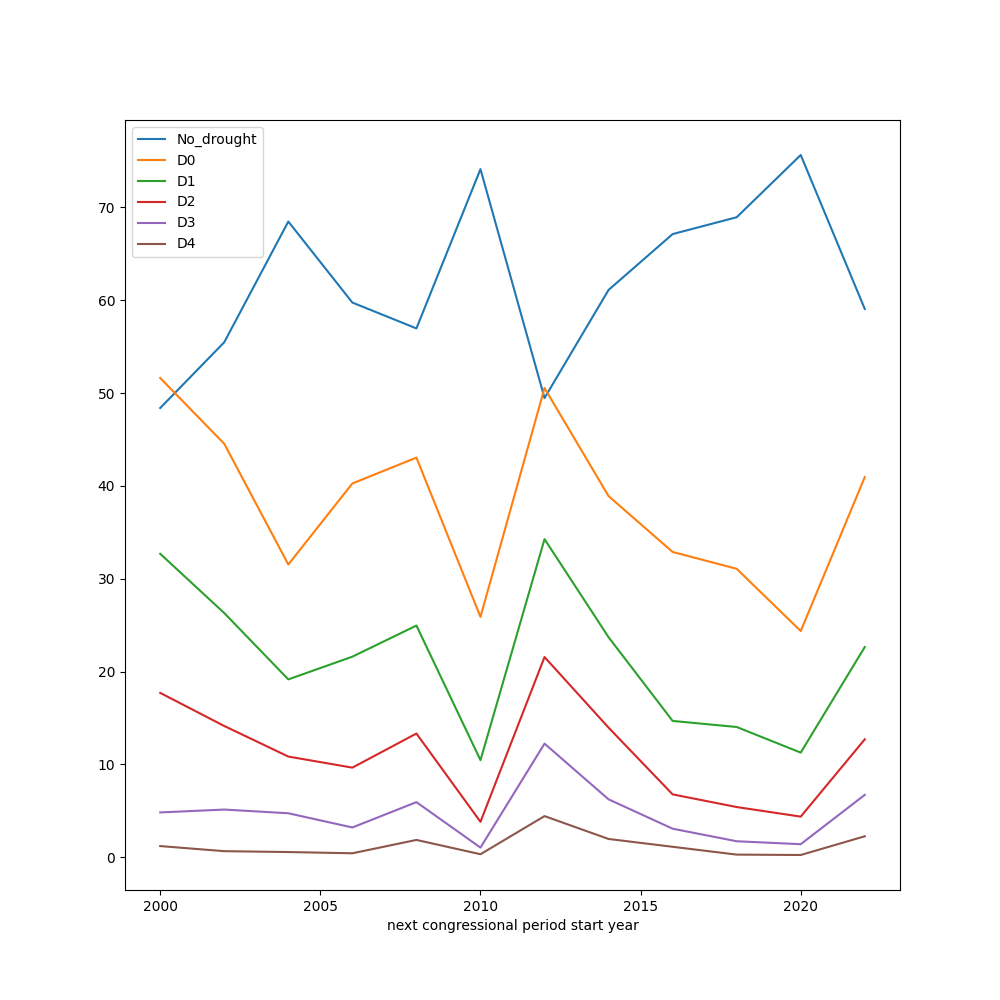

<AxesSubplot:xlabel='next congressional period start year'>

In [306]:
drought_df.reset_index().groupby(['next congressional period start year']).mean().plot(figsize=(10,10))

# Geo Data Import and Cleaning

In [32]:
import geopandas as gpd
import shapely
from shapely.geometry import Polygon
from descartes import PolygonPatch

## US County Shapefiles

from https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html  
under "County"  
filename "cb_2018_us_county_500k.zip"

should maybe redo this with higher granularity (but probably won't change much)

In [189]:
county_shp = gpd.read_file(r"C:\Users\mikha\OneDrive\Desktop\Dropbox\MIKHAEL NEW\mikhael school\Grad School\Master's\Term 2 Classes\544\Replication\My Addition\County Shapefiles (2018)\cb_2018_us_county_500k.shp")

### Uppercase

In [190]:
county_shp = county_shp.applymap(lambda s:s.upper() if type(s) == str else s)

In [191]:
county_shp['STATEFP'] = county_shp['STATEFP'].astype('int64')
county_shp['COUNTYFP'] = county_shp['COUNTYFP'].astype('int64')
county_shp['COUNTYNS'] = county_shp['COUNTYNS'].astype('int64')
county_shp['GEOID'] = county_shp['GEOID'].astype('int64')
county_shp['ALAND'] = county_shp['ALAND'].astype('int64')
county_shp['AWATER'] = county_shp['AWATER'].astype('int64')

#drop DC - it doesn't have any congressional rep's
county_shp = county_shp[county_shp['STATEFP'] != 11]

### Refine some county name entries

In [192]:
# fix some county name problems (e.g. 'st.'-->'saint')

county_shp['NAME'] = [x.replace('ST.', 'SAINT').replace('LASALLE','LA SALLE') for x in county_shp['NAME']]

county_shp['NAME'] = county_shp['NAME'].astype(str).replace('ST.','SAINT').replace('LASALLE','LA SALLE')

for word in county_stopwords:
    county_shp['NAME'] = [x.replace(word,'') for x in county_shp['NAME']]

### Convert county_shp['STATEFP'] to state

In [193]:
state_to_fips = pd.read_csv(r"C:\Users\mikha\OneDrive\Desktop\Dropbox\MIKHAEL NEW\mikhael school\Grad School\Master's\Term 2 Classes\544\Replication\My Addition\State to FIPS Conversion.csv")

In [194]:
# create a dictionary mapping FIPS codes to US States

fips_to_state_dict = {}

for i,row in state_to_fips.iterrows():
    fips_to_state_dict[row['FIPS']] = row['State']

In [195]:
county_shp['state'] = county_shp['STATEFP'].apply(lambda x: fips_to_state_dict[x])

In [196]:
county_shp = county_shp.applymap(lambda s:s.upper() if type(s) == str else s)

## Congressional District Shapefiles

source: http://cdmaps.polisci.ucla.edu/

**NOTE**: TRY TO FIND DATA FOR 2018 AND 2020

can get districts back to 2011 here (in R) https://rdrr.io/cran/tigris/man/congressional_districts.html 

### Import

In [197]:
congress_2015_2017 = gpd.read_file(r"C:\Users\mikha\OneDrive\Desktop\Dropbox\MIKHAEL NEW\mikhael school\Grad School\Master's\Term 2 Classes\544\Replication\My Addition\Congressional District Shapefiles\114th - J 2015 - J 2017\districtShapes\districts114.shp")
congress_2013_2014 = gpd.read_file(r"C:\Users\mikha\OneDrive\Desktop\Dropbox\MIKHAEL NEW\mikhael school\Grad School\Master's\Term 2 Classes\544\Replication\My Addition\Congressional District Shapefiles\113th - J 2013 to D 2014\districtShapes\districts113.shp")
congress_2011_2013 = gpd.read_file(r"C:\Users\mikha\OneDrive\Desktop\Dropbox\MIKHAEL NEW\mikhael school\Grad School\Master's\Term 2 Classes\544\Replication\My Addition\Congressional District Shapefiles\112th - J 2011 - J 2013\districtShapes\districts112.shp")
congress_2009_2010 = gpd.read_file(r"C:\Users\mikha\OneDrive\Desktop\Dropbox\MIKHAEL NEW\mikhael school\Grad School\Master's\Term 2 Classes\544\Replication\My Addition\Congressional District Shapefiles\111th - J 2009 - D 2010\districtShapes\districts111.shp")
congress_2007_2009 = gpd.read_file(r"C:\Users\mikha\OneDrive\Desktop\Dropbox\MIKHAEL NEW\mikhael school\Grad School\Master's\Term 2 Classes\544\Replication\My Addition\Congressional District Shapefiles\110th - J 2007 - J 2009\districtShapes\districts110.shp")
congress_2005_2006 = gpd.read_file(r"C:\Users\mikha\OneDrive\Desktop\Dropbox\MIKHAEL NEW\mikhael school\Grad School\Master's\Term 2 Classes\544\Replication\My Addition\Congressional District Shapefiles\109th - J 2005 - D 2006\districtShapes\districts109.shp")
congress_2003_2005 = gpd.read_file(r"C:\Users\mikha\OneDrive\Desktop\Dropbox\MIKHAEL NEW\mikhael school\Grad School\Master's\Term 2 Classes\544\Replication\My Addition\Congressional District Shapefiles\108th -\districts108.shp")
congress_2001_2002 = gpd.read_file(r"C:\Users\mikha\OneDrive\Desktop\Dropbox\MIKHAEL NEW\mikhael school\Grad School\Master's\Term 2 Classes\544\Replication\My Addition\Congressional District Shapefiles\107th - J 2001 - N 2002\districtShapes\districts107.shp")
congress_1999_2000 = gpd.read_file(r"C:\Users\mikha\OneDrive\Desktop\Dropbox\MIKHAEL NEW\mikhael school\Grad School\Master's\Term 2 Classes\544\Replication\My Addition\Congressional District Shapefiles\106th - J 1999 - D 2000\districtShapes\districts106.shp")
congress_1997_1998 = gpd.read_file(r"C:\Users\mikha\OneDrive\Desktop\Dropbox\MIKHAEL NEW\mikhael school\Grad School\Master's\Term 2 Classes\544\Replication\My Addition\Congressional District Shapefiles\105th - J 1997 - D 1998\districtShapes\districts105.shp")

### Merge into one DF

In [198]:
congress_2015_2017['election year'] = 2014
congress_2013_2014['election year'] = 2012
congress_2011_2013['election year'] = 2010
congress_2009_2010['election year'] = 2008
congress_2007_2009['election year'] = 2006
congress_2005_2006['election year'] = 2004
congress_2003_2005['election year'] = 2002
congress_2001_2002['election year'] = 2000
congress_1999_2000['election year'] = 1998
congress_1997_1998['election year'] = 1996

merged_district_df = pd.concat([congress_1997_1998, congress_1999_2000, congress_2001_2002,
                          congress_2003_2005, congress_2005_2006, congress_2007_2009,
                          congress_2009_2010, congress_2011_2013, congress_2013_2014,
                          congress_2015_2017], ignore_index=True)


del congress_1997_1998, congress_1999_2000, congress_2001_2002,congress_2003_2005, congress_2005_2006, congress_2007_2009, congress_2009_2010, congress_2011_2013, congress_2013_2014, congress_2015_2017


merged_district_df.columns = ['state',
 'ID',
 'district',
 'STARTCONG',
 'ENDCONG',
 'DISTRICTSI',
 'COUNTY',
 'PAGE',
 'LAW',
 'NOTE',
 'BESTDEC',
 'RNOTE',
 'FROMCOUNTY',
 'LASTCHANGE',
 'FINALNOTE',
 'geometry',
 'election year']

## Drop districts with invalid geometry

In [199]:
# drop NaN geometry
merged_district_df = merged_district_df[merged_district_df['geometry'].isna()==False]

In [200]:
merged_district_df = merged_district_df[merged_district_df['geometry'].is_valid == True]

### Convert district to integer

In [201]:
merged_district_df['district'] = merged_district_df['district'].astype(int)

### Uppercase

In [202]:
merged_district_df = merged_district_df.applymap(lambda s:s.upper() if type(s) == str else s)

## County boundary changes

Not worrying about these now - 41/3000+ counties changed borders over this 20 year period (roughly 1%)

**NOTE:MAYBE SHOULD JUST DROP THESE (AND MAKE A DF OF ALL DROPPED COUNTIES WITH REASONS FOR DROPPING)**

In [203]:
county_changes_shp = gpd.read_file(r"C:\Users\mikha\OneDrive\Desktop\Dropbox\MIKHAEL NEW\mikhael school\Grad School\Master's\Term 2 Classes\544\Replication\My Addition\Historical County Shapefiles\US_AtlasHCB_Counties_Gen001\US_HistCounties_Gen001_Shapefile\US_HistCounties_Gen001.shp")

In [204]:
county_changes_shp['year'] = county_changes_shp['START_DATE'].astype(str).str[:4].astype(int)

### Drop all obs for years we don't have data (pre-BASE_YEAR) 

In [205]:
county_changes_shp = county_changes_shp[county_changes_shp['year'] >= BASE_YEAR]

In [206]:
print(f"There are {len(county_changes_shp)} changes to US Counties from {BASE_YEAR} to present")

There are 41 changes to US Counties from 1998 to present


### Still have to do something with the changes in county boundaries

Maybe just drop them? There are very few, should be fine if it isn't in one of our $\approx 60$ agricultural congressional districts

### Uppercase

In [207]:
county_changes_shp = county_changes_shp.applymap(lambda s:s.upper() if type(s) == str else s)

In [208]:
len(merged_district_df)

4284

In [209]:
# merged_district_df = merged_district_df[merged_district_df['geometry'].is_valid == True]

## Create dictionaries for counties in district & districts in county

This takes around 50 minutes on my machine... so once you've run it once I recommend saving the two dictionaries as JSONs and commenting this out

### OPTION 1: Create these dictionaries (if you haven't already)

Takes a really long time

In [741]:
from tqdm import tqdm

In [742]:
# counties_in_district_dict[state][year][district] = list of counties in that cong. district. specifically, (county_x, county x as % of district y land area)
# districts_from_county_dict[state][year][county] = list of cong. districts that this county is a part of

counties_in_district_dict = {}
districts_from_county_dict = {}

for state in tqdm(list(set(merged_district_df['state']))): #nothing special about this df - it's just a list of states
    counties_in_district_dict[state] = {}
    districts_from_county_dict[state] = {}
    
    for year in list(set(elec_df['year'])):
        if 2000 <= year <= 2014: #limit to years we have data for
            counties_in_district_dict[state][year] = {}
            districts_from_county_dict[state][year] = {}

            for county in county_shp[county_shp['state']==state]['NAME']:
                districts_from_county_dict[state][year][county] = []

            for district in list(set(merged_district_df[(merged_district_df['state']==state) & (merged_district_df['election year']==year)]['district'])): #loop over all districts from the state and year
                counties_in_district_dict[state][year][district] = []

                #iterate only over same state in both dfs (county and district), otherwise this would probably take forever
                for i1,district_row in merged_district_df[(merged_district_df['state']==state) & (merged_district_df['election year']==year) & (merged_district_df['district']==district)].iterrows():
                    for i2,county_row in county_shp[county_shp['state']==state].iterrows():

                        if district_row['geometry'].intersects(county_row['geometry']):
                            intersec = district_row['geometry'].intersection(county_row['geometry']).area
                            intersection_over_district_area = intersec / district_row['geometry'].area
                            intersection_over_county_area = intersec / county_row['geometry'].area

                            counties_in_district_dict[state][year][district].append(tuple([county_row['NAME'], intersection_over_district_area])) #add name, (area of county & district overlap) / (total district area) as tuple. this is the list of counties that are in a district, with county overlap as a percentage of district area
                            districts_from_county_dict[state][year][county_row['NAME']].append(tuple([district, intersection_over_county_area])) #add name, (area of county & district overlap) / (total county area) as tuple. this is the list of districts that are in a county, with district overlap as a percentage of county area

100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [43:34<00:00, 53.36s/it]


#### Save geodicts as files so you don't have to calculate intersections again

In [210]:
import json 

json.dump( counties_in_district_dict, open( "counties_in_district_dict.json", 'w' ) )
json.dump( districts_from_county_dict, open( "districts_from_county_dict.json", 'w' ) )


# load with 
# counties_in_district_dict = json.load( open( "counties_in_district_dict.json" ) )
# districts_from_county_dict = json.load( open( "districts_from_county_dict.json" ) )

#### Double-check that each county's district areas sum to $\approx$ 1

Maybe county shps are less precise than districts'?

In [211]:
counties_that_dont_belong = {'state':[], 'year':[], 'county':[], 'pct coverage':[]}

for state in districts_from_county_dict:
    for year in districts_from_county_dict[state]:
        if 2000 <= year <= 2014:
            for county in districts_from_county_dict[state][year]:
                if not .95 <= sum([x[1] for x in districts_from_county_dict[state][year][county]]) <= 1.01:
#                     print(state, year, county, sum([x[1] for x in districts_from_county_dict[state][year][county]]))
                    counties_that_dont_belong['state'].append(state)
                    counties_that_dont_belong['year'].append(year)                
                    counties_that_dont_belong['county'].append(county)                
                    counties_that_dont_belong['pct coverage'].append(sum([x[1] for x in districts_from_county_dict[state][year][county]]))                
                
messed_up_counties = pd.DataFrame(counties_that_dont_belong)

TypeError: '<=' not supported between instances of 'int' and 'str'

In [ ]:
print(f'there are {len(messed_up_counties)} messed up county observations out of approx {round(len(county_shp)*(2014-2000)/2)}, or {100 * len(messed_up_counties) / round(len(county_shp)*(2014-2000)/2)}%')

so roughly 2/3 counties are screwed up... weird because counties in districts appear to be totalled up correctly

#### Double-check that each district's counties sum up to $\approx 1$

looks good :)

In [212]:
for state in counties_in_district_dict:
    for year in counties_in_district_dict[state]:
        for district in counties_in_district_dict[state][year]:
            if sum([x[1] for x in counties_in_district_dict[state][year][district]]) <= .98 or sum([x[1] for x in counties_in_district_dict[state][year][district]]) > 1.01:
                print(state, year, district, sum([x[1] for x in counties_in_district_dict[state][year][district]]))

LOUISIANA 2012 1 0.969899242346452
LOUISIANA 2014 1 0.969899242346452


### OPTION 2: load dictionaries from JSON (if you've already created them)

In [213]:
counties_in_district_dict = json.load( open( "counties_in_district_dict.json" ) )
districts_from_county_dict = json.load( open( "districts_from_county_dict.json" ) )

# Trends in Congressional Voting Analysis (dependent var)

### Import

In [214]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Total Turnout

### Notes

Here, I fit a simple trendline through turnout data. This is done individually for each district and year.

This analysis allows us to compare actual turnout to expected turnout. Eventually, this will be used to see if drought leads to changes relative to the trend. 

Formula is $$\text{totalturnout} = \text{year} + \text{DPres}$$,

where $\text{DPres}=1(\text{Presidential Election Year})$

Using 'HC3' robust standard errors - cite: https://jslsoc.sitehost.iu.edu/files_research/testing_tests/hccm/00TAS.pdf

Need to collapse subsets further, since they're now basically weighted by number of contestants in each election (although I've already deleted non-major parties, so weight should be essentially equal over the years at ~2 per year). In sum, not an issue to worry about right now.  
* Just to confirm this, $correlation(\text{" year of election"}, \text{"turnout - predicted"}) = 2.951465137113311e-13 \approx 0$

I use simple linear regression (without exponentials) because polynomial regressions would overfit these small, highly variable samples. Also, growth in total votes cast looks roughly constant over time https://www.statista.com/statistics/1139763/number-votes-cast-us-presidential-elections/

### Over all observed years

In [215]:
"""
steps in this code cell:
1) select subsets of observations by state and district (e.g. MD 8th district over all years observed)
2) regress 'totalturnout ~ year + DPres'
3) put residuals back into subset
"""

elec_df['turnout_minus_predicted_all_years'] = np.nan #will iteratively fill below

for state in set(elec_df['state']):
    for district in set(elec_df[elec_df['state']==state]['district']):
        
        subset = elec_df[(elec_df['state']==state) & (elec_df['district'] == district)]
        regression_filter = (elec_df['state']==state) & (elec_df['district'] == district)

        regression = smf.ols(formula='totalturnout ~ year + DPres', data=subset)
        regression_result = regression.fit(cov_type='HC3')

        elec_df.loc[regression_filter, 'turnout_minus_predicted_all_years'] = regression_result.resid  #how is this loc correct??!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!      
#         elec_df.loc[regression_filter, 'turnout - predicted'] = regression_result.resid

C:\Users\mikha\Anaconda\envs\geopandas_env\lib\site-packages\statsmodels\regression\linear_model.py:1908: RuntimeWarning: divide by zero encountered in true_divide
  self.het_scale = (self.wresid / (1 - h))**2
C:\Users\mikha\Anaconda\envs\geopandas_env\lib\site-packages\statsmodels\regression\linear_model.py:1908: RuntimeWarning: divide by zero encountered in true_divide
  self.het_scale = (self.wresid / (1 - h))**2


#### Confirm that this worked

looks pretty good - red points are residuals from regression

<IPython.core.display.Javascript object>


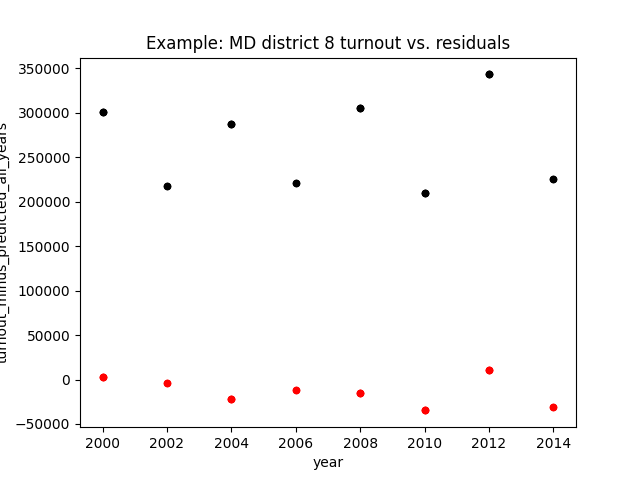

[]

In [242]:
plotting_subset = elec_df[(elec_df['state']=='MARYLAND') & (elec_df['district'] == 8)]

ax1 = plotting_subset.plot.scatter(x='year', y='totalturnout', color='black')
ax2 = plotting_subset.plot.scatter(x='year', y='turnout_minus_predicted_all_years', color='red', ax=ax1)
ax1.set_title('Example: MD district 8 turnout vs. residuals')
ax1.plot()

### ONLY Over years we have drought data for

In [217]:
"""
identical steps in this cell as the one above
"""

elec_df['turnout_-_predicted_(observed_years)'] = np.nan #will iteratively fill below

for state in set(elec_df['state']):
    for district in set(elec_df[elec_df['state']==state]['district']):
        try:
            subset = elec_df[(elec_df['state']==state) & (elec_df['district'] == district) & (elec_df['year'] >= BASE_YEAR)]
            regression_filter = (elec_df['state']==state) & (elec_df['district'] == district) & (elec_df['year'] >= BASE_YEAR)

            regression = smf.ols(formula='totalturnout ~ year + DPres', data=subset)
            regression_result = regression.fit(cov_type='HC3')

            elec_df.loc[regression_filter, 'turnout_-_predicted_(observed_years)'] = regression_result.resid
        except:
            pass

## Republican Vote Share

### Over all observed years

In [218]:
# same steps as for "Total Turnout"

elec_df['Republican_pred_voteshare_minus_actual_all_years'] = np.nan #will iteratively fill below

for state in set(elec_df['state']):
    for district in set(elec_df[elec_df['state']==state]['district']):
        subset = elec_df[(elec_df['state']==state) & (elec_df['district'] == district)]
        regression_filter = (elec_df['state']==state) & (elec_df['district'] == district)

        regression = smf.ols(formula='Repub_voteshare ~ year + DPres', data=subset)
        regression_result = regression.fit(cov_type='HC3')

        elec_df.loc[regression_filter, 'Republican_pred_voteshare_minus_actual_all_years'] = regression_result.resid

### Over drought years

In [219]:
# same steps as for "Total Turnout"

elec_df['Republican_pred_voteshare_minus_actual_observed_years'] = np.nan #will iteratively fill below

for state in set(elec_df['state']):
    for district in set(elec_df[elec_df['state']==state]['district']):
        try:
            subset = elec_df[(elec_df['state']==state) & (elec_df['district'] == district) & (elec_df['year'] >BASE_YEAR)]
            regression_filter = (elec_df['state']==state) & (elec_df['district'] == district) & (elec_df['year'] >= BASE_YEAR)

            regression = smf.ols(formula='Repub_voteshare ~ year + DPres', data=subset)
            regression_result = regression.fit(cov_type='HC3')

            elec_df.loc[regression_filter, 'Republican_pred_voteshare_minus_actual_observed_years'] = regression_result.resid
        except:
            pass

## Democrat Vote Share

### Over all observed years

In [220]:
# same steps as for "Total Turnout"

elec_df['Democrat_pred_voteshare_minus_actual_all_years'] = np.nan #will iteratively fill below

for state in set(elec_df['state']):
    for district in set(elec_df[elec_df['state']==state]['district']):
        try:
            subset = elec_df[(elec_df['state']==state) & (elec_df['district'] == district)]
            regression_filter = (elec_df['state']==state) & (elec_df['district'] == district)

            regression = smf.ols(formula='Dem_voteshare ~ year + DPres', data=subset)
            regression_result = regression.fit(cov_type='HC3')

            elec_df.loc[regression_filter, 'Democrat_pred_voteshare_minus_actual_all_years'] = regression_result.resid
        except:
            pass

C:\Users\mikha\Anaconda\envs\geopandas_env\lib\site-packages\statsmodels\regression\linear_model.py:1908: RuntimeWarning: divide by zero encountered in true_divide
  self.het_scale = (self.wresid / (1 - h))**2
C:\Users\mikha\Anaconda\envs\geopandas_env\lib\site-packages\statsmodels\regression\linear_model.py:1908: RuntimeWarning: divide by zero encountered in true_divide
  self.het_scale = (self.wresid / (1 - h))**2


### Over drought years

In [221]:
# same steps as for "Total Turnout"

elec_df['Democrat_pred_voteshare_minus_actual_(observed_years)'] = np.nan #will iteratively fill below

for state in set(elec_df['state']):
    for district in set(elec_df[elec_df['state']==state]['district']):
        try:
            subset = elec_df[(elec_df['state']==state) & (elec_df['district'] == district) & (elec_df['year'] >= BASE_YEAR)]
            regression_filter = (elec_df['state']==state) & (elec_df['district'] == district) & (elec_df['year'] >= BASE_YEAR)

            regression = smf.ols(formula='Dem_voteshare ~ year + DPres', data=subset)
            regression_result = regression.fit(cov_type='HC3')

            elec_df.loc[regression_filter, 'Democrat_pred_voteshare_minus_actual_(observed_years)'] = regression_result.resid
        except:
            pass

# Combine county and district data (independent var)

i.e. bring county drought data to congressional districts

## Create dictionary matching districts and drought by period

In [222]:
district_drought_dict = {}

for state in counties_in_district_dict:
    district_drought_dict[state] = {}
    
    for year in counties_in_district_dict[state]:
        district_drought_dict[state][int(year)] = {}
        
        for district in counties_in_district_dict[state][year]:
            try:
                avg_drought_over_period = sum(drought_df.loc[state_abbrev_dict[state.upper()], int(year), county[0]]*county[1] for county in counties_in_district_dict[state][year][district])  #this is weighted by the percent of a district each county accounts for. e.g. if 1/4 of a district is a county in full drought, and the other 3/4 is a county with no drought, the district ends up with 1/4 drought (roughly speaking) 

                district_drought_dict[state][int(year)][int(district)] = avg_drought_over_period

            except Exception as e:
                print(e)
#                 pass # at this point, these are just two strangely spelled counties that don't matter for the analysis - would fix if had time

('MO', 2000, 'STE. GENEVIEVE')
('MO', 2000, 'STE. GENEVIEVE')
('MO', 2002, 'STE. GENEVIEVE')
('MO', 2002, 'STE. GENEVIEVE')
('MO', 2004, 'STE. GENEVIEVE')
('MO', 2004, 'STE. GENEVIEVE')
('MO', 2006, 'STE. GENEVIEVE')
('MO', 2006, 'STE. GENEVIEVE')
('MO', 2008, 'STE. GENEVIEVE')
('MO', 2008, 'STE. GENEVIEVE')
('MO', 2010, 'STE. GENEVIEVE')
('MO', 2010, 'STE. GENEVIEVE')
('MO', 2012, 'STE. GENEVIEVE')
('MO', 2014, 'STE. GENEVIEVE')
('NM', 2000, 'DE BACA')
('NM', 2000, 'DE BACA')
('NM', 2002, 'DE BACA')
('NM', 2002, 'DE BACA')
('NM', 2004, 'DE BACA')
('NM', 2004, 'DE BACA')
('NM', 2006, 'DE BACA')
('NM', 2006, 'DE BACA')
('NM', 2008, 'DE BACA')
('NM', 2008, 'DE BACA')
('NM', 2010, 'DE BACA')
('NM', 2010, 'DE BACA')
('NM', 2012, 'DE BACA')
('NM', 2012, 'DE BACA')
('NM', 2014, 'DE BACA')
('NM', 2014, 'DE BACA')


## Turn this into a dataframe

In [223]:
district_drought_df = pd.DataFrame.from_dict({(state,year,district): district_drought_dict[state][year][district] 
                           for state in district_drought_dict.keys() 
                           for year in district_drought_dict[state].keys()
                           for district in district_drought_dict[state][year].keys()},
                       orient='index')

In [224]:
district_drought_df.index.names = ['state', 'year', 'district']

## Merge this dataframe with elec_df

note that this drops observations before 2000

In [225]:
elec_df = elec_df.set_index(['state', 'year', 'district']).merge(district_drought_df, on=['state', 'year', 'district']).reset_index()

# Final Data Prep for Analysis

## Create a few more necessary variables

### Create Drought Measure Variable

**NOTE: THERE ARE MANY FORMULATIONS ONE COULD USE HERE. THEY WOULD PROBABLY AFFECT THE ANALYSIS**

#### First, inversely weight levels of drought by their rarity (JUST OVER AGRICULTURAL DISTRICTS)

In [285]:
elec_df.rename(columns={'None':'No_drought'}, inplace=True) #THIS HOPEFULLY ISN'T NECESSARY WHEN EVERYTHIGN IS RUN IN ORDER

levels_of_drought_weight_dict = {}

levels_of_drought = ['No_drought', 'D0', 'D1', 'D2', 'D3', 'D4']

for level in levels_of_drought:
    
    levels_of_drought_weight_dict[level] = 1 / elec_df[elec_df['agricultural']==1].groupby(by=['state', 'year', 'district']).mean()[level].mean() #this is the mean after collapsing down to each election (so there isn't more weight on elections with more candidates)
    
#     print(level, elec_df[elec_df['agricultural']==1][level].mean(), elec_df[elec_df['agricultural']==1].groupby(by=['state', 'year', 'district']).mean()[level].mean())

#### Then, take inner product:

$$\text{drought inner product} = \sum_i{level_i * weight_i}$$

In [286]:
elec_df['drought inner prod'] = sum(elec_df[level]*levels_of_drought_weight_dict[level] for level in levels_of_drought)

#### Finally, normalize to proportion

In [287]:
max_drought = sum(100*levels_of_drought_weight_dict[level] for level in levels_of_drought)
elec_df['drought_score'] = elec_df['drought inner prod'] / max_drought

In [288]:
print(f'max value of "drought_score" is {elec_df["drought_score"].max()}')

max value of "drought_score" is 0.530846655518427


In [289]:
#normalize to 100

elec_df['drought_score'] = elec_df['drought_score']*(1/elec_df["drought_score"].max())*100

In [290]:
elec_df['drought_score'].hist(log=True)

<AxesSubplot:xlabel='Drought Score Relative to District Average', ylabel='Republican Predicted Voteshare Minus Actual'>

### Create Average Drought variable

Should I also create a var for the biggest drought that they've seen? (averaging over future years too doesn't make much sense)

In [291]:
# elec_df = elec_df.reset_index()
state_set = set(elec_df['state'])
year_set = set(elec_df['year'])

levels_of_drought = ['No_drought', 'D0', 'D1', 'D2', 'D3', 'D4', 'drought_score']

for level in levels_of_drought:
    elec_df[level + '_avg'] = np.nan
#     elec_df[level + 'vs_avg'] = np.nan

for state in state_set:
    for district in set(elec_df[elec_df['state']==state]['district']):
        state_district_filter = (elec_df['state']==state) & (elec_df['district']==district)
        
        for level in levels_of_drought:
            
            elec_df.loc[state_district_filter, str(level + '_avg')] = elec_df[state_district_filter][level].mean()  #take average
            
            
for level in levels_of_drought:
    elec_df[level + '_vs_avg'] = elec_df[level] - elec_df[level + '_avg']

### Classify major droughts

note: this is arbitrary - see if there's an official definition

In [292]:
major_drought_filter = (elec_df['D3'] >= 40)
major_unexpected_drought_filter = elec_df['D3_vs_avg'] >= 20

elec_df["major_drought"] = major_drought_filter
elec_df['major_unexpected_drought'] = major_unexpected_drought_filter

print(f'there are {sum(major_drought_filter)} observations of major_drought')
print(f'there are {sum(major_unexpected_drought_filter)} observations of major_unexpected_drought')

there are 240 observations of major_drought
there are 421 observations of major_unexpected_drought


### Convert year to str (for dummy vars)

In [293]:
elec_df['year'] = elec_df['year'].astype(str)

### Incumbent Lost

In [294]:
elec_df['incumbent_lost'] = elec_df['incumbent'] * (1 - elec_df['winner'])

### Collapse elec_df (so there isn't more weight on elections with more candidates)

In [295]:
collapsed_elec_df = elec_df.groupby(by=['state', 'year', 'district']).mean().reset_index()

### Set of independent variables

* No results when interact with DPres
* Results when don't interact

Results significant at 10% level for both non-interacted specifications

In [296]:
indep_var_str = 'drought_score*agricultural + DPres + state + year'
continuous_agr_indep_vars = 'drought_score_vs_avg*agricultural_gdp + DPres + state + year'

# Preliminary Analysis and Graphing

\begin{equation} \text{turnout}_{it} = Drought_{it} + Drought_{it} \times D_{agricultural} + ... \end{equation}

\begin{equation} D_{\text{incumbent lost}, it} = Drought_{it} + Drought_{it} \times D_{agricultural} + ...  \end{equation}

\begin{equation} \text{R vote share}_{it} = Drought_{it} + Drought_{it} \times D_{agricultural} + ... \end{equation}

## \begin{equation} \text{totalturnout}_{it} = Drought_{it} + Drought_{it} \times D_{agricultural} + ... \end{equation}

### Graph shows no strong trend

In [274]:
%matplotlib notebook
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


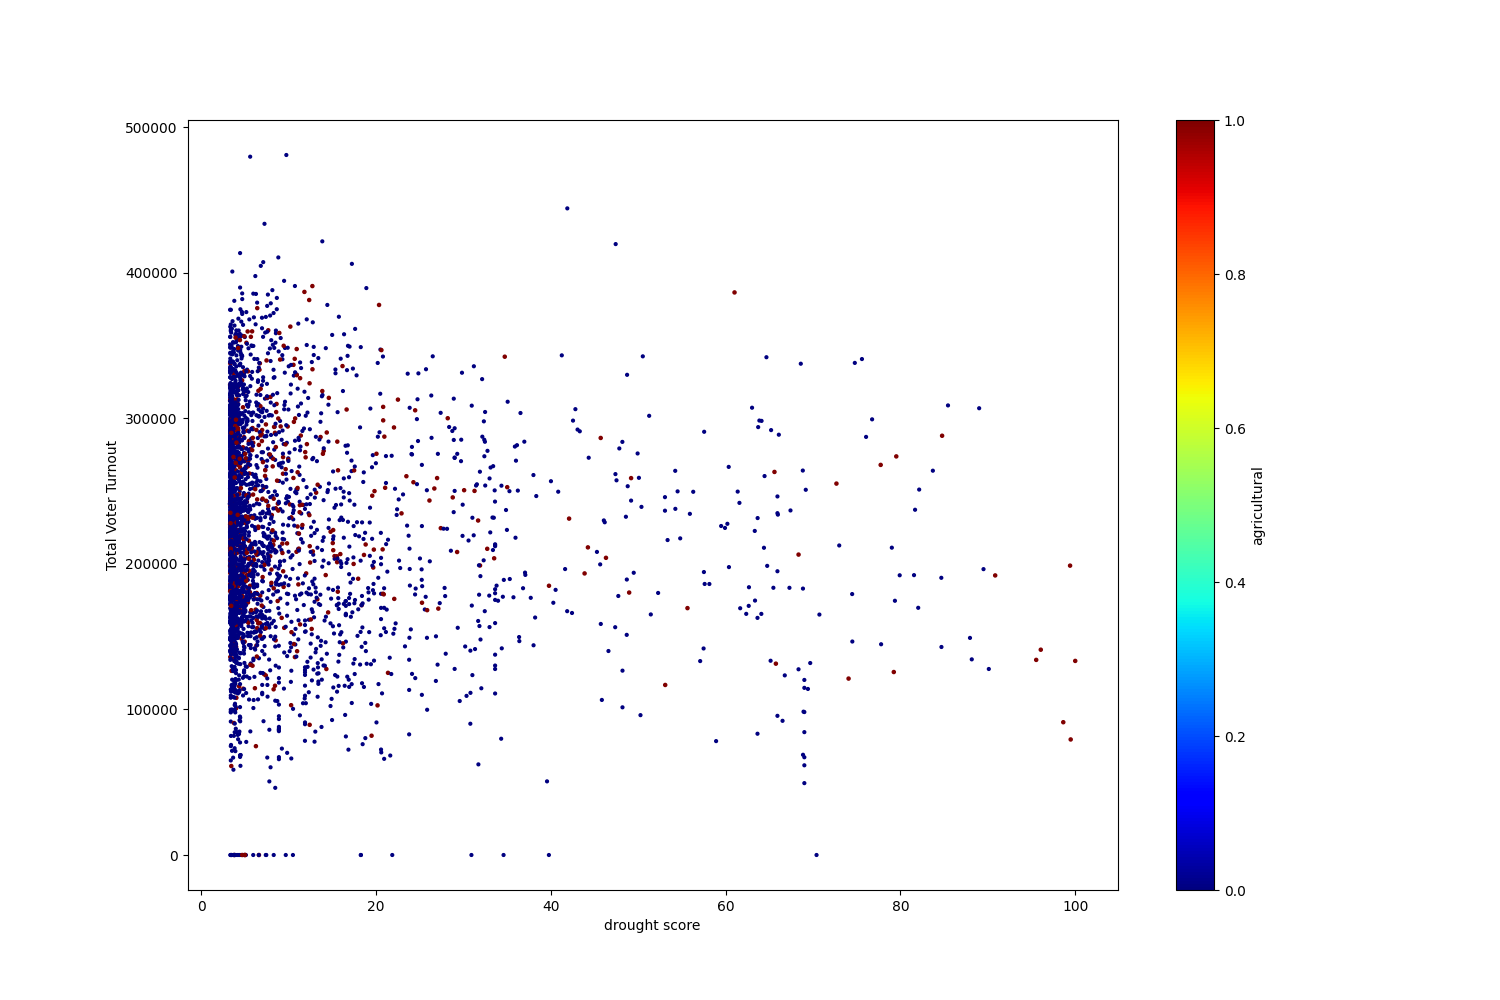

In [297]:
collapsed_elec_df.plot.scatter(x='drought_score', y='totalturnout', c='agricultural', colormap='jet', figsize=(15,10), xlabel='drought score', ylabel = 'Total Voter Turnout', s=collapsed_elec_df['agricultural'] + 4).autoscale()

<IPython.core.display.Javascript object>


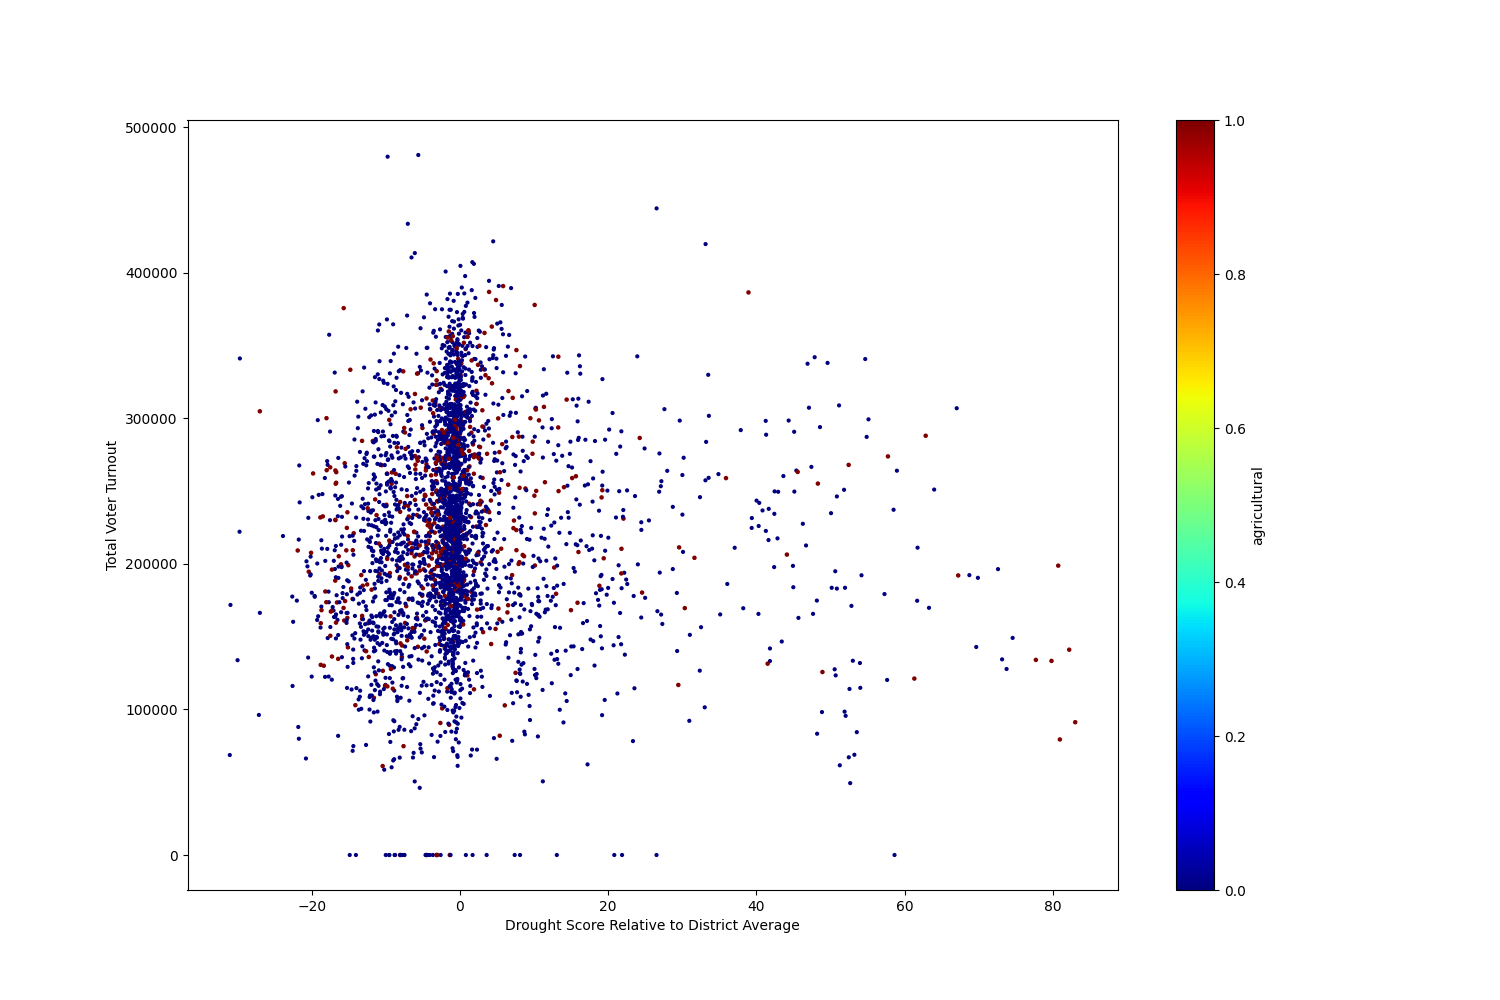

In [298]:
collapsed_elec_df.plot.scatter(x='drought_score_vs_avg', y='totalturnout', c='agricultural', colormap='jet', figsize=(15,10), xlabel='Drought Score Relative to District Average', ylabel = 'Total Voter Turnout', s=collapsed_elec_df['agricultural'] + 4).autoscale()

### Regression

In [299]:
turnout_change_regression = smf.ols(formula=f'totalturnout ~ {continuous_agr_indep_vars}', data=collapsed_elec_df)
# turnout_change_regression_result = turnout_change_regression.fit(cov_type='cluster', cov_kwds={'groups':collapsed_elec_df['state']}) #this might not be the right kind of standard error
turnout_change_regression_result = turnout_change_regression.fit(cov_type='HC0') #this might not be the right kind of standard error
print(turnout_change_regression_result.summary())

                            OLS Regression Results                            
Dep. Variable:           totalturnout   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     2549.
Date:                Fri, 05 Mar 2021   Prob (F-statistic):               0.00
Time:                        22:44:18   Log-Likelihood:                -41231.
No. Observations:                3391   AIC:                         8.258e+04
Df Residuals:                    3332   BIC:                         8.294e+04
Df Model:                          58                                         
Covariance Type:                  HC0                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

C:\Users\mikha\Anaconda\envs\geopandas_env\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 59, but rank is 57
  warnings.warn('covariance of constraints does not have full '


### Idea: *collect major_unexpected_drought[T.True]:agricultural:DPres[T.True]* coefficients as I change drought classification

## \begin{equation} D_{\text{incumbent }\Delta \text{ in voteshare} , it} = Drought_{it} + Drought_{it} \times D_{agricultural} + ...  \end{equation}

<IPython.core.display.Javascript object>


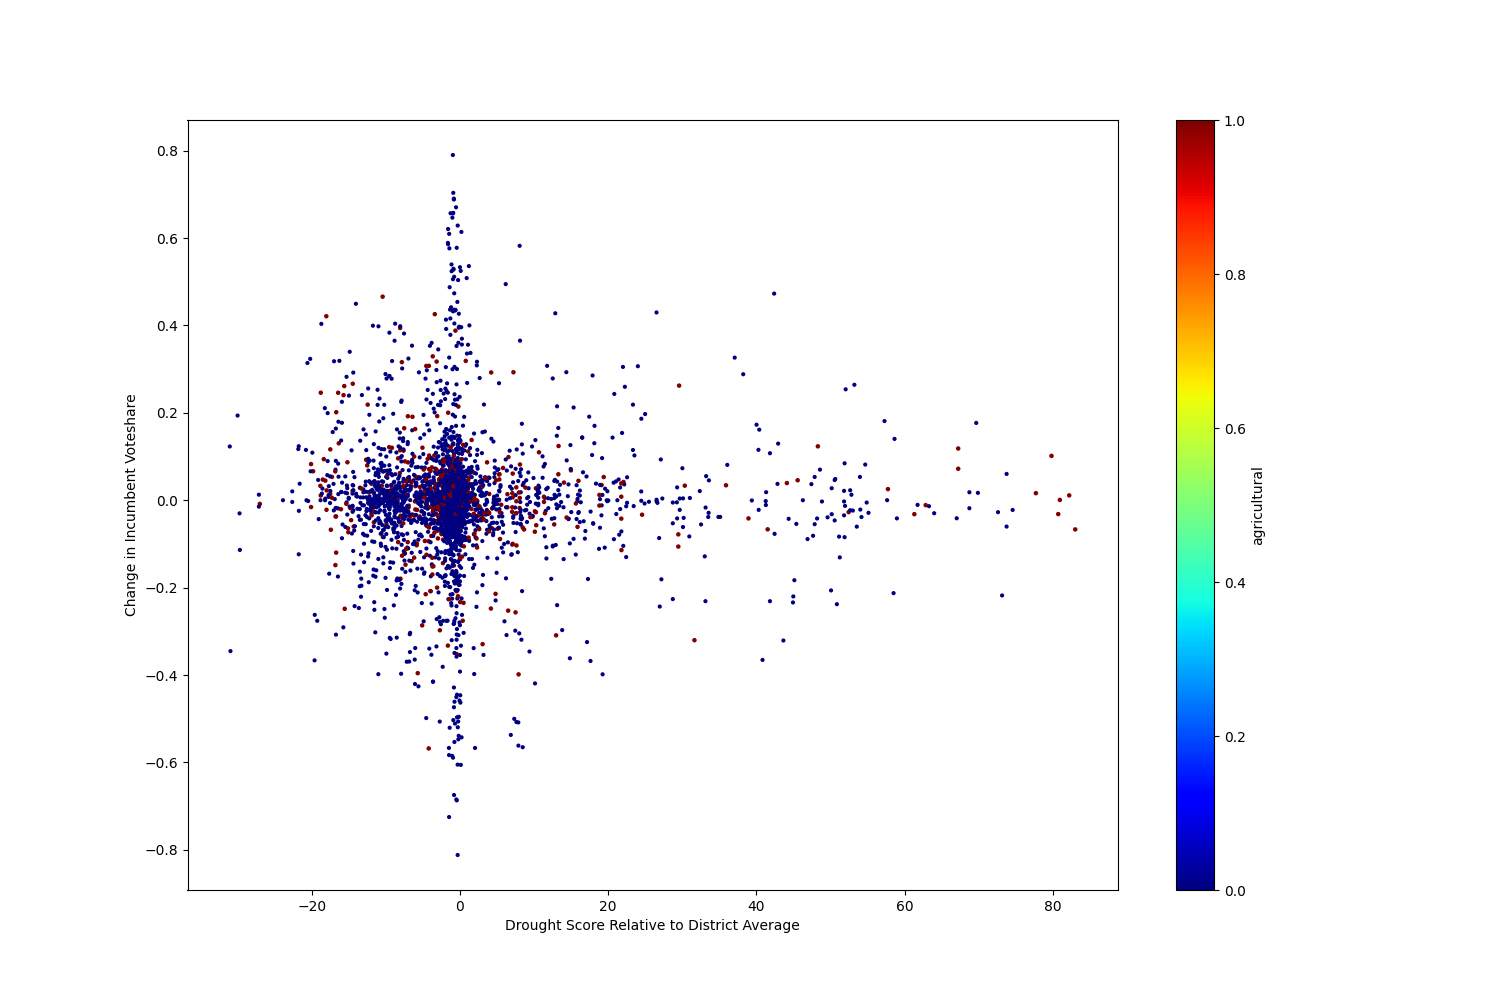

In [300]:
elec_df.plot.scatter(x='drought_score_vs_avg', y='share_diff', c='agricultural', colormap='jet', figsize=(15,10), xlabel='Drought Score Relative to District Average', ylabel = 'Change in Incumbent Voteshare', s=elec_df['agricultural'] + 4).autoscale()

In [301]:
#note that I use the uncollapsed elec_df here - shouldn't make a difference, since all non-incumbent observations are nan

incumbent_voteshare_change_regression = smf.ols(formula='share_diff ~ drought_score_vs_avg*agricultural*DPres + state + year', data=elec_df)
# incumbent_voteshare_change_regression_result = incumbent_voteshare_change_regression.fit(cov_type='cluster', cov_kwds={'groups':collapsed_elec_df['state']}) #this might not be the right kind of standard error
incumbent_voteshare_change_regression_result = incumbent_voteshare_change_regression.fit(cov_type='HC0') #this might not be the right kind of standard error
print(incumbent_voteshare_change_regression_result.summary())

                            OLS Regression Results                            
Dep. Variable:             share_diff   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.7232
Date:                Fri, 05 Mar 2021   Prob (F-statistic):              0.949
Time:                        22:44:55   Log-Likelihood:                 1558.6
No. Observations:                2985   AIC:                            -2993.
Df Residuals:                    2923   BIC:                            -2621.
Df Model:                          61                                         
Covariance Type:                  HC0                                         
                                                      coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------

## \begin{equation} D_{\text{incumbent lost}, it} = Drought_{it} + Drought_{it} \times D_{agricultural} + ...  \end{equation}

Worth noting that incumbents lose about 2% of the time

In [302]:
incumbent_lost_ols_regression = smf.ols(formula=f'incumbent_lost ~ {indep_var_str}', data=collapsed_elec_df)
incumbent_lost_ols_regression_result = incumbent_lost_ols_regression.fit(cov_type='HC0')
# incumbent_lost_ols_regression_result = incumbent_lost_ols_regression.fit(cov_type='cluster', cov_kwds={'groups':collapsed_elec_df['state']})
print(incumbent_lost_ols_regression_result.summary())

                            OLS Regression Results                            
Dep. Variable:         incumbent_lost   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     2.507
Date:                Fri, 05 Mar 2021   Prob (F-statistic):           2.53e-09
Time:                        22:44:58   Log-Likelihood:                 3107.1
No. Observations:                3391   AIC:                            -6096.
Df Residuals:                    3332   BIC:                            -5735.
Df Model:                          58                                         
Covariance Type:                  HC0                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [281]:
# incumbent_lost_logit_regression = smf.logit(formula=f'incumbent_lost ~ {indep_var_str}', data=collapsed_elec_df)
# incumbent_lost_logit_regression_result = incumbent_lost_logit_regression.fit(cov_type = 'HC0')
# print(incumbent_lost_logit_regression_result.summary())

## \begin{equation} \text{R vote share}_{it} = Drought_{it} + Drought_{it} \times D_{agricultural} + ... \end{equation}

<IPython.core.display.Javascript object>


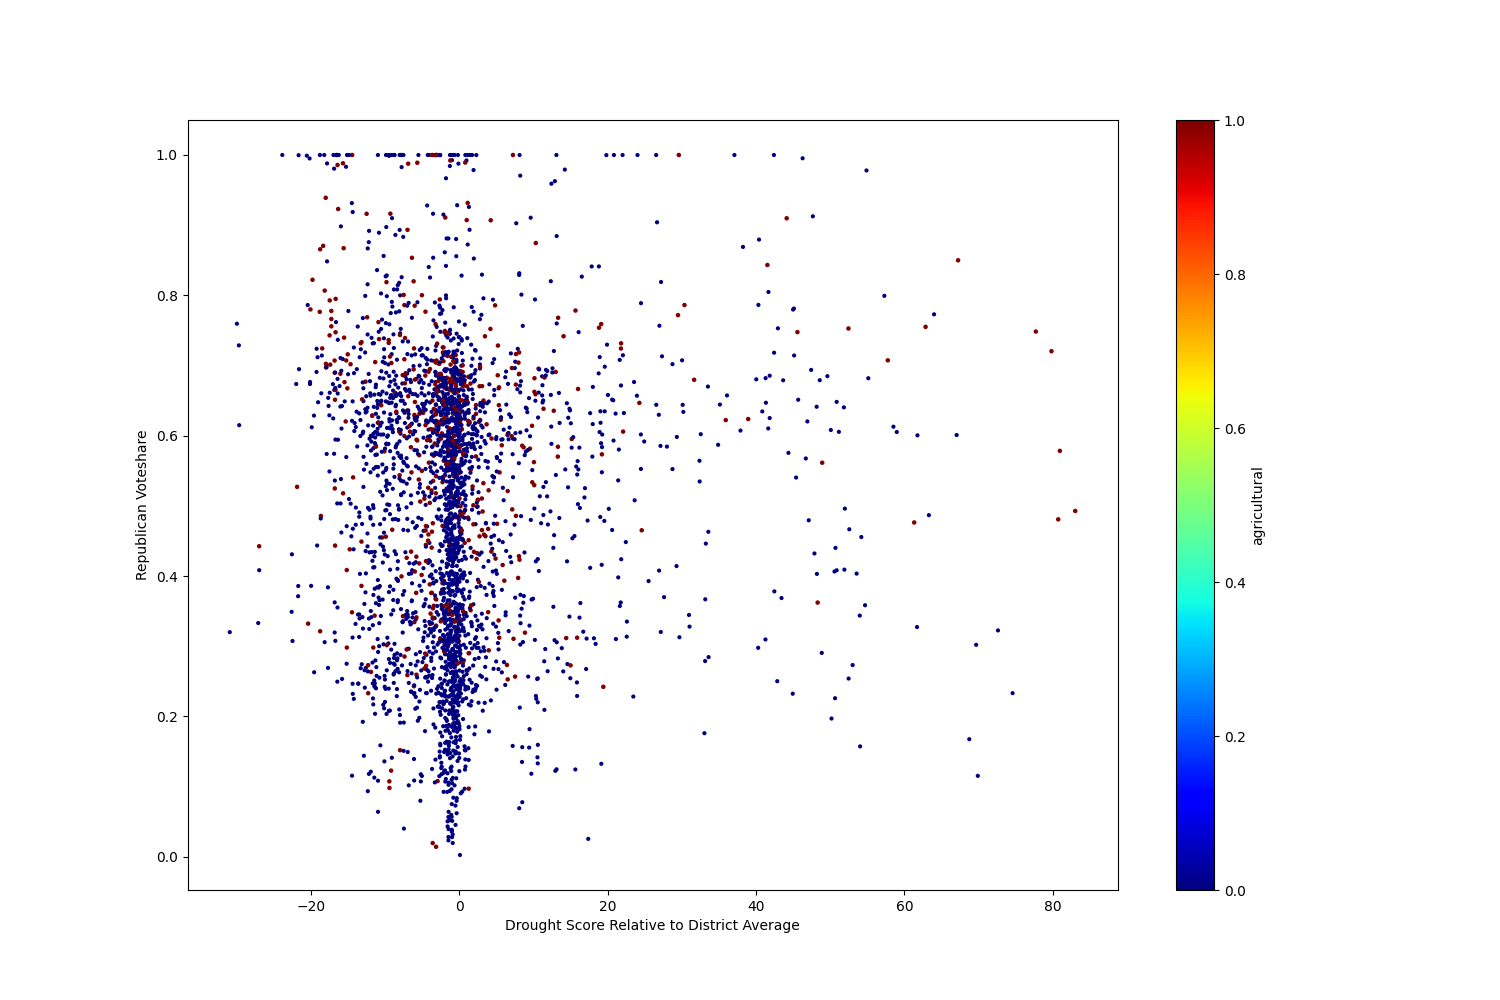

In [303]:
collapsed_elec_df.plot.scatter(x='drought_score_vs_avg', y='Repub_voteshare', c='agricultural', colormap='jet', figsize=(15,10), xlabel='Drought Score Relative to District Average', ylabel = 'Republican Voteshare', s=collapsed_elec_df['agricultural'] + 4).autoscale()

<IPython.core.display.Javascript object>


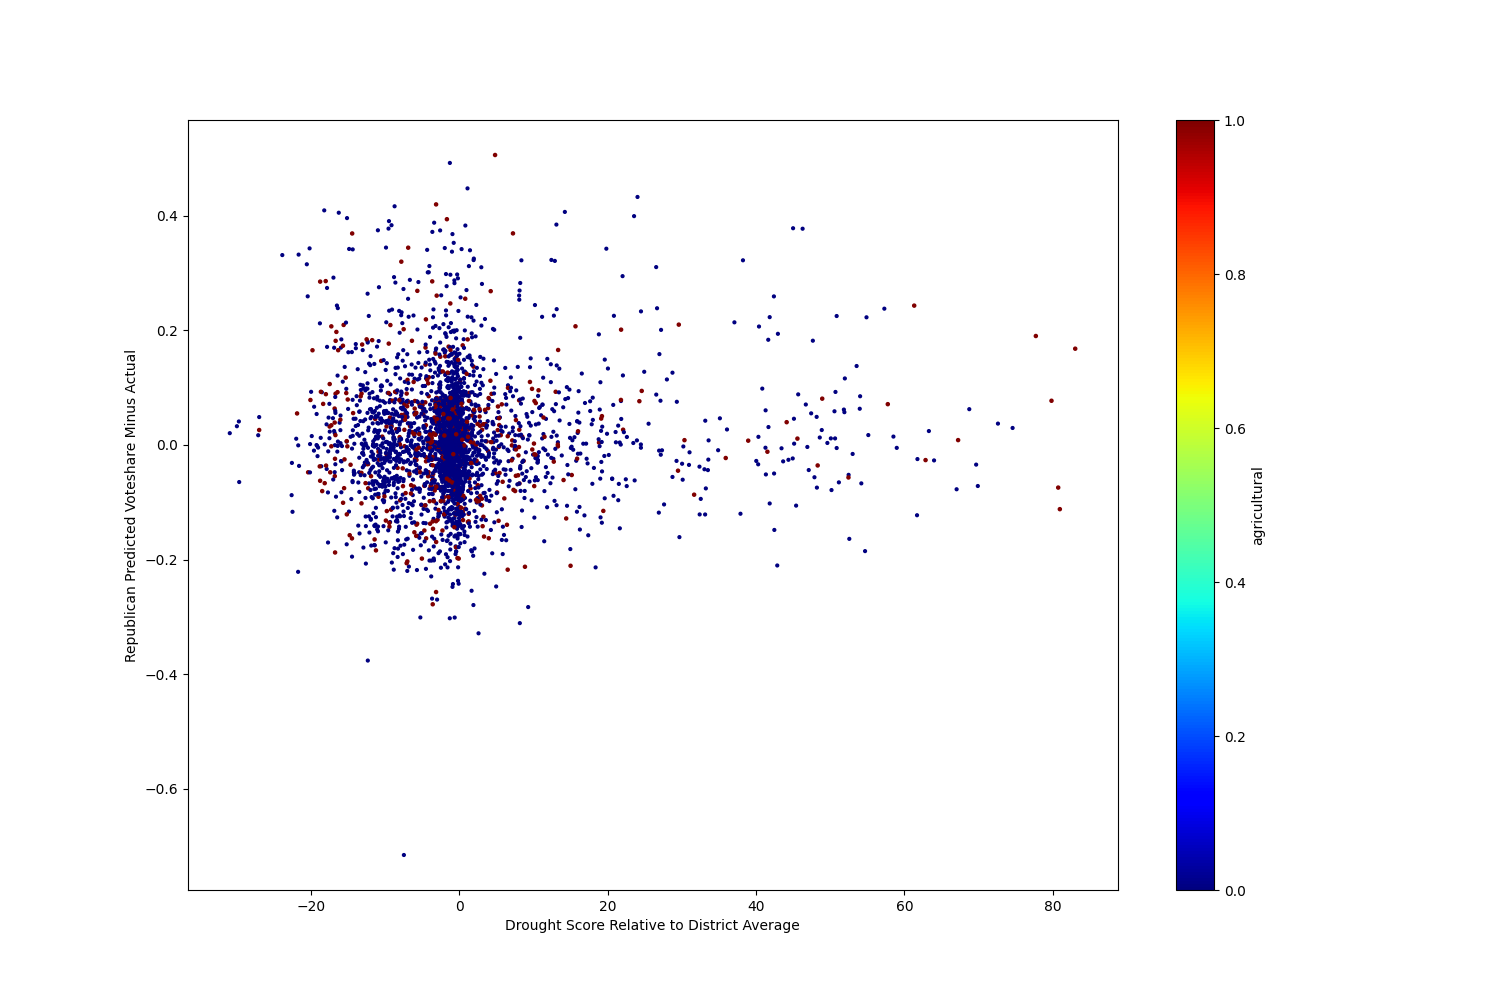

In [304]:
collapsed_elec_df.plot.scatter(x='drought_score_vs_avg', y='Republican_pred_voteshare_minus_actual_all_years', c='agricultural', colormap='jet', figsize=(15,10), xlabel='Drought Score Relative to District Average', ylabel = 'Republican Predicted Voteshare Minus Actual', s=collapsed_elec_df['agricultural'] + 4).autoscale()

In [305]:
rep_voteshare_ols_regression = smf.logit(formula=f'Repub_voteshare ~ {indep_var_str}', data=collapsed_elec_df)
rep_voteshare_ols_regression_result = rep_voteshare_ols_regression.fit(cov_type = 'HC0')
print(rep_voteshare_ols_regression_result.summary())

Optimization terminated successfully.
         Current function value: 0.655516
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:        Repub_voteshare   No. Observations:                 3048
Model:                          Logit   Df Residuals:                     2989
Method:                           MLE   Df Model:                           58
Date:                Fri, 05 Mar 2021   Pseudo R-squ.:                 0.05420
Time:                        22:45:15   Log-Likelihood:                -1998.0
converged:                       True   LL-Null:                       -2112.5
Covariance Type:                  HC0   LLR p-value:                 3.590e-22
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.5806    3.4e+06   1.71e-07      1.000   -6.

# Export to csv

In [307]:
elec_df.to_csv("elec_df.csv", index=False)
collapsed_elec_df.to_csv("collapsed_elec_df.csv", index=False)